# Endovis17 Binary Image Segmentation Baseline using UNet

In [1]:
import torch
import torchvision
import torchvision.transforms.v2 as v2
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from pathlib import Path

torch.set_float32_matmul_precision('medium')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

## Creating the Dataset

In [2]:
class Endovis17BinaryDataset(Dataset):
    def __init__(self,root_data_dir:Path,patient_set:list[int],target_size=None,test = False):
            # collecting the frame files
            self.frames_dir = root_data_dir / "frames"  / ("test" if test else "train")
            self.frame_dirs = [self.frames_dir / f"instrument_dataset_{p:02d}" for p in patient_set]
            # check that all dirs exist
            for dir in self.frame_dirs:
                assert dir.exists(), f"Directory {dir} does not exist"
            self.frame_file_names = [file.absolute() for frame_dir in self.frame_dirs for file in frame_dir.iterdir()]
            # collecting the mask files
            self.masks_dir = root_data_dir / "masks" / ("test" if test else "train") / "binary_masks"
            self.mask_dirs = [self.masks_dir / f"instrument_dataset_{p:02d}" for p in patient_set]
            # check that all dirs exist
            for dir in self.mask_dirs:
                assert dir.exists(), f"Directory {dir} does not exist"
            self.mask_file_names = [file.absolute() for mask_dir in self.mask_dirs for file in mask_dir.iterdir()]

            # check that the number of frames and masks is the same
            assert len(self.frame_file_names) == len(self.mask_file_names), "Number of frames and masks is not the same"

            self.to_tensor = v2.ToDtype(torch.float32, scale=True)
            self.target_size = target_size

    def __len__(self):
        return len(self.frame_file_names)

    def __getitem__(self, idx):
        frame_path = self.frame_file_names[idx]
        mask_path = self.mask_file_names[idx]
        frame = torchvision.io.read_image(frame_path)
        mask = torchvision.io.read_image(mask_path)
        frame = self.to_tensor(frame)
        mask = self.to_tensor(mask)
        if self.target_size:
            frame = torch.nn.functional.interpolate(frame.unsqueeze(dim=0), size=self.target_size, mode='bilinear').squeeze(dim=0)
            mask = torch.nn.functional.interpolate(mask.unsqueeze(dim=0), size=self.target_size, mode='nearest').squeeze(dim=0) 
        return frame, mask

### Create the Train Loader and Test Loader

In [3]:
DATA_DIR = Path("../data")
# orginal_image_size = 1280 x 1024
test_patient_set = [9,10]
train_dataset = Endovis17BinaryDataset(DATA_DIR,[1])
test_dataset = Endovis17BinaryDataset(DATA_DIR,test_patient_set,test=True) 

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=8,num_workers=8, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=8,num_workers=8)

Train dataset size: 225
Test dataset size: 600


### Viewing Samples

torch.Size([3, 1024, 1280])


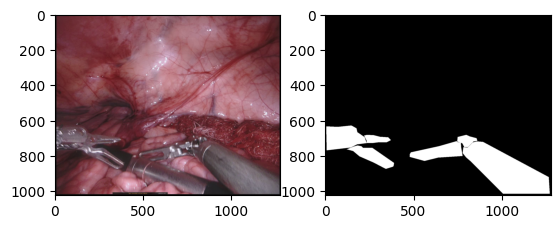

torch.Size([3, 1024, 1280])


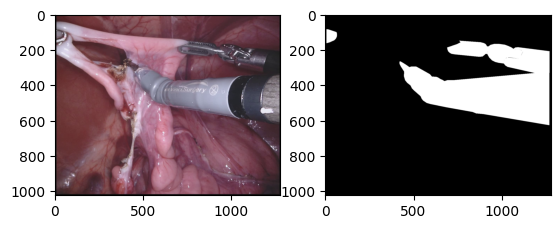

In [4]:
sample = train_dataset[0]
plt.subplot(1,2,1)
print(sample[0].shape)
plt.imshow(sample[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(sample[1].squeeze(),cmap='gray')
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
print(sample[0].shape)
plt.imshow(sample[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(sample[1].squeeze(),cmap='gray')
plt.show()

## Model

In [5]:
EPOCHS = 10
T_MAX = EPOCHS * len(train_loader) 
OUT_CLASSES = 1

In [9]:
class InstrumentsUNetModel(pl.LightningModule):
    def __init__(self, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.Unet(encoder_name,5,"imagenet", in_channels, classes=out_classes, **kwargs)
        self.loss = torch.nn.BCEWithLogitsLoss()

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    
    def forward(self, image):
        # normalize the image
        x = (image - self.mean) / self.std
        return self.model(x)

    def shared_step(self, batch, stage):
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }
    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        metrics = { f"{stage}_per_image_iou": per_image_iou }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return {
            "optimizer": optimizer,
        }

In [10]:
model = InstrumentsUNetModel(
    encoder_name="resnet34",
    in_channels=3,
    out_classes=OUT_CLASSES,
)

In [ ]:
trainer = pl.Trainer(max_epochs=EPOCHS,log_every_n_steps=1)
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=test_loader,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type              | Params | Mode 
------------------------------------------------------
0 | model   | Unet              | 24.4 M | train
1 | loss    | BCEWithLogitsLoss | 0      | train
2 | loss_fn | DiceLoss          | 0      | train
------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)
190       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]